[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/broadinstitute/g2papi/blob/main/examples/ex3_large_scale_variant_characterization/large_scale_variant_characterization.ipynb)

In [74]:
# @title Large Scale Variant Characterization

# @markdown ## Download ClinVar variants (not needed)

#! wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

#! gunzip variant_summary.txt.gz

In [100]:
# @markdown ## Collect Gene Data
gene_list = [
    ("BRCA1", "P38398"),
    ("PTEN", "P60484"),
    ("KRAS", "P01116"),
    ("TP53", "P04637")
]

# @markdown ### Load List of Genes

import g2papi
import pandas as pd

chaperones = pd.read_csv("query results.csv")
chaperones.head()

,id,UniProt,Symbol,Name,Target Development Level,IDG Family,Novelty
0,192,P61604,HSPE1,"10 kDa heat shock protein, mitochondrial",Tbio,Other,0.000744
1,908,Q58FF3,HSP90B2P,Putative endoplasmin-like protein,Tdark,Other,NaN
2,909,P14625,HSP90B1,Endoplasmin,Tchem,Other,0.001359
3,1824,Q9HAV7,GRPEL1,"GrpE protein homolog 1, mitochondrial",Tbio,Other,0.001853
4,1825,Q8TAA5,GRPEL2,"GrpE protein homolog 2, mitochondrial",Tbio,Other,0.526602


In [ ]:
# @markdown ### Get Protein Features for the G2P portal Protein Feature API

from tqdm.notebook import tqdm

protein_features_by_gene = {}

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = g2papi.get_protein_features(gene, uniprot_id)

    protein_features_by_gene[gene] = protein_features


  0%|          | 0/110 [00:00<?, ?it/s]

In [103]:
# @markdown ## Normalize Protein Features

# @markdown ### Define Functions to Normalize Protein Features

# @markdown For Categorical Features, we will use one-hot encoding, and for quantitative features, we will scale the values.

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re


def is_uniprot(col):
    return "(UniProt)" in col

def is_ptm(col):
    return col in [
        "Acetylation",
        "Disease-associated PTMs",
        "Methylation",
        "O-GalNAc",
        "O-GlcNAc",
        "Phosphorylation",
        "SNP-associated PTMs",
        "Regulatory sites",
        "Substrate genes",
        "SUMOylation",
        "Ubiquitination",
    ]

def is_pocket(col):
    return col == "Pocket number (fpocket)*"

def is_ppi(col):
    is_pdb_ppi = ("bond (PDB)" in col) or ("interaction (PDB)" in col) \
       or ("bridge (PDB)" in col)
    is_af2_ppi = ("bond (AlphaFold2)" in col) or ("interaction (AlphaFold2)" in col) \
       or ("bridge (AlphaFold2)" in col)
    
    return is_pdb_ppi or is_af2_ppi

def is_mave_outlier(col):
    return bool(re.match(r'^\d{7,9}-[a-z0-9]-\d{1,3} outliers⁺⁺$', col))


def is_categorical(col):
    categorical_cols = [
        "Amino acid residues",
        "Amino acid properties",
        "Secondary structure (PDBe/SIFTS)",
        "Secondary structure (DSSP 3-state)*",
        "Secondary structure (DSSP 9-state)*"
    ]

    return is_uniprot(col) or col in categorical_cols \
       or is_ptm(col) or is_ppi(col) or is_mave_outlier(col) \
       or is_pocket(col)

def non_nan_always_1(col):

    matches = is_uniprot(col) or is_ptm(col) \
        or is_ppi(col) or is_mave_outlier(col) \
        or is_pocket(col)
    #print(col, matches)
    return matches


# for all columns starting with amino acid columns, normalize quantitative columns and 
# use one hot encoding for categorical variables

def normalize_gene_data(gene_data):
    # Make a copy to avoid modifying the original data
    df = gene_data.copy()
    
    # Excluding chain and AA which are unique identifiers
    amino_acid_cols = [col for col in df.columns if col not in ['residueId', 'AA']]
    
    # Process each column
    normalized_df = df[['residueId', 'AA']].copy()

    normalized_cols = []
    
    for col in amino_acid_cols:
        try:
            # Check if column is numeric
            if not is_categorical(col):
                # Normalize numeric columns using StandardScaler
                # First handle any NaN value

                col_data = df[col].fillna(df[col].mean())
                scaler = StandardScaler()
                normalized_cols.append(pd.DataFrame(
                    scaler.fit_transform(col_data.values.reshape(-1, 1)),
                    columns=[f"{col}_normalized"],
                    index=df.index
                ))
            else:
                #print(col)
                # For categorical columns, apply one-hot encoding
                if non_nan_always_1(col):
                    col_data = df[col].notna().astype(int)

                    normalized_cols.append(pd.DataFrame(
                        col_data,
                        columns=[col],
                        index=df.index
                    ))
                else:
                    #print(col, 2)

                    # First handle any NaN values
                    #col_data = df[col].fillna('Unknown')
                    col_data = df[col]
                    
                    # Apply one-hot encoding
                    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                    encoded = encoder.fit_transform(col_data.values.reshape(-1, 1))
                    
                    # Create new columns for each category
                    categories = encoder.categories_[0]

                    normalized_cols.append(pd.DataFrame(
                        encoded,
                        columns=[f"{col}_{category}" for category in categories],
                        index=df.index
                    ))
        except:
            print(f"Failed process for col {col}")
    
    all_dfs = [normalized_df] + normalized_cols
    normalized_df = pd.concat(all_dfs, axis=1)
    
    return normalized_df



In [105]:
# @markdown ### Normalize Protein Features for Each Gene

normalized_data = []

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = protein_features_by_gene[gene]
    normalized_df = normalize_gene_data(protein_features)
    normalized_df["gene"] = gene # add a gene col
    normalized_data.append(normalized_df)


  0%|          | 0/110 [00:00<?, ?it/s]

/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_coun

Failed process for col Druggability score (fpocket)*
Failed process for col Druggability score (fpocket)*
Failed process for col Druggability score (fpocket)*


/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_coun

In [106]:
# @markdown ## Now make a simple model to predict breaking/not breaking HO hydrogen bond

# @markdown ### Concatenate all normalized data and drop MAVE columns which are specific to a single gene

final_df = pd.concat(normalized_data)


to_drop = []
for col in final_df.columns:
    if is_mave_outlier(col) or "avg_normalized" in col:
        to_drop.append(col)


final_df = final_df.drop(columns=to_drop)


final_df = final_df.fillna(0)



In [107]:
# @markdown ## Construct Model Labels and Features

def is_hydrogen_bond(col):
    return "Hydrogen bond" in col

hb_cols = [col for col in final_df.columns if is_hydrogen_bond(col)]


# model label: if there is a hydrogen bond present
y = (final_df[hb_cols].sum(axis=1) > 0).astype(int)

cols_to_skip = hb_cols + ["residueId", "AA", "gene"]
X = final_df.drop(columns=cols_to_skip)

In [108]:
# @markdown ## Split Data into Training and Testing Sets

test_percentage = 0.2 # @param {type:"number"}

from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_percentage, random_state=42, stratify=y
)

# Print dataset sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Positive labels (training): {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Positive labels (test): {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Training set: 41595 samples
Test set: 10399 samples
Positive labels (training): 26485 (63.67%)
Positive labels (test): 6621 (63.67%)


In [109]:
# @markdown ## Fit a simple Logistic Regression Model to the Training Data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Initialize a logistic regression model
# You can adjust regularization strength with C parameter (smaller C = stronger regularization)
model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# @markdown ## Evaluate the Model on the Test Set

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Display top positive and negative coefficients
print("\nTop 10 Most Positive Features:")
print(feature_importance.head(10))
print("\nTop 10 Most Negative Features:")
print(feature_importance.tail(10))

Accuracy: 0.9193
ROC AUC: 0.9698

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      3778
           1       0.92      0.95      0.94      6621

    accuracy                           0.92     10399
   macro avg       0.92      0.91      0.91     10399
weighted avg       0.92      0.92      0.92     10399


Top 10 Most Positive Features:
                                             Feature  Coefficient
92          Inter-chain Non-bonded interaction (PDB)     3.359374
94                     Inter-chain Salt bridge (PDB)     3.061493
50                    Initiator methionine (UniProt)     2.427156
90                     Intra-chain Salt bridge (PDB)     2.406818
87   Intra-chain Non-bonded interaction (AlphaFold2)     2.400284
16                   Amino acid properties_Aliphatic     2.260249
86          Intra-chain Non-bonded interaction (PDB)     2.254995
101  Secondary structure (DSSP 9-state)*_I (π-helix)    

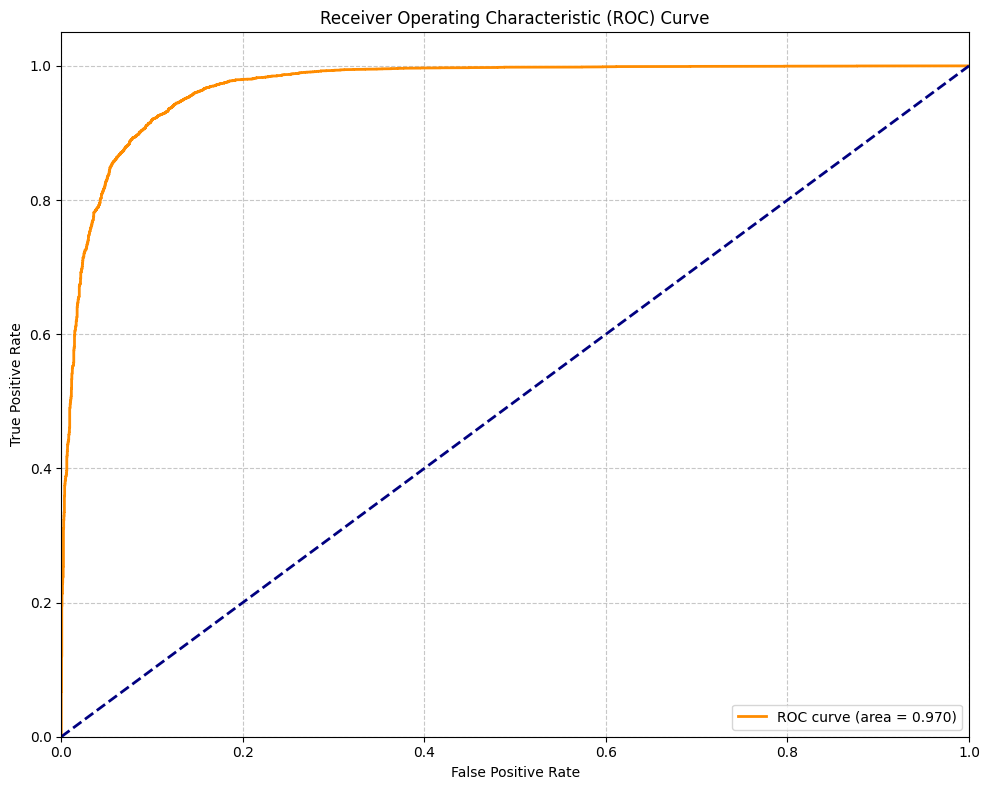

In [ ]:
# @markdown ## Plot ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()